## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Oct  5 23:01:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |   1727MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import matplotlib.pyplot as plt
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **12.02.2023** with version **YOLOv8.0.28**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.28

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.7/78.2 GB disk)


In [ ]:
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Inference with Pre-trained COCO Model

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

Saving patas3.jpg to patas3 (1).jpg


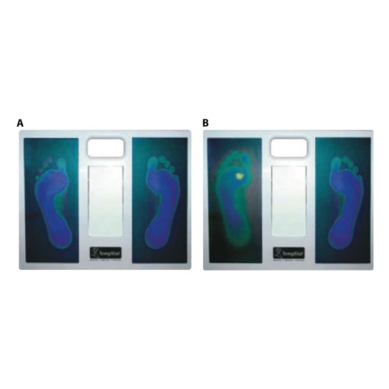

In [ ]:
def resize_image(image_path):
    # Lee la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convierte de BGR a RGB

    # Obtiene las dimensiones de la imagen
    height, width = image.shape[:2]

    # Determina el factor de escala
    if max(height, width) > 640:
        # Si la imagen es más grande que 640 en cualquier dimensión, reduce su tamaño
        scale_factor = 640.0 / max(height, width)
    else:
        # Si la imagen es más pequeña que 640 en ambas dimensiones, amplía su tamaño
        scale_factor = 640.0 / max(height, width)

    # Calcula las nuevas dimensiones
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    # Redimensiona la imagen
    resized_image = cv2.resize(image, (new_width, new_height))

    # Crea una imagen base blanca de 640x640
    base_image = np.ones((640, 640, 3), dtype=np.uint8) * 255

    # Calcula las coordenadas para centrar la imagen redimensionada en la imagen base
    x_offset = (640 - new_width) // 2
    y_offset = (640 - new_height) // 2

    # Coloca la imagen redimensionada en la imagen base
    base_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image

    return base_image

# Carga una imagen desde tu computadora
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Redimensiona la imagen y agrega espacio vacío
img = resize_image(image_path)

# Muestra la imagen resultante
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model = YOLO(f'{HOME}/yolov8s-seg.pt')
results = model.predict(source=img, conf=0.25)

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

0: 640x640 1 person, 2 tvs, 21.2ms
Speed: 0.6ms pre-process, 21.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
def apply_mask(image, mask):
    # Asegura que la máscara sea binaria (0 o 1)
    binary_mask = np.where(mask > 0, 1, 0)

    # Multiplica la imagen por la máscara para obtener el recorte
    masked_image = image * binary_mask[:, :, np.newaxis]

    return masked_image

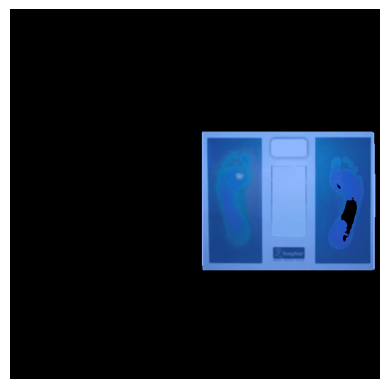

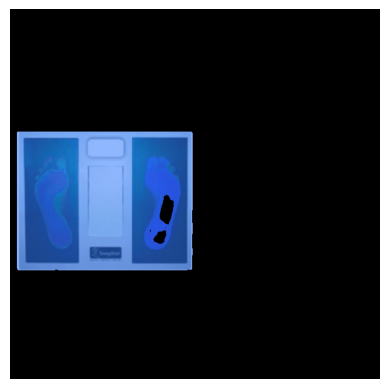

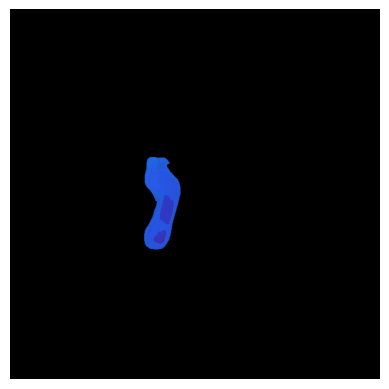

In [ ]:
for r in results:
    masks=r.masks.masks.cpu().numpy()
    for mask in masks:
        masked_img = apply_mask(img, mask)
        plt.imshow(masked_img)
        plt.axis('off')
        plt.show()

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

/content/datasets


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="jJdTgDUjarers534fZoc")
project = rf.workspace("chela").project("pies")
dataset = project.version(3).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.28, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Pies-3 in yolov8:: 100%|██████████| 444/444 [00:00<00:00, 5082.01it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640

/content
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/Pies-3/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fal

In [ ]:
!ls {HOME}/runs/segment/train/

args.yaml					    MaskR_curve.png
BoxF1_curve.png					    results.csv
BoxP_curve.png					    results.png
BoxPR_curve.png					    train_batch0.jpg
BoxR_curve.png					    train_batch1.jpg
confusion_matrix.png				    train_batch2.jpg
events.out.tfevents.1696546948.42ba78a6354f.2034.0  val_batch0_labels.jpg
MaskF1_curve.png				    val_batch0_pred.jpg
MaskP_curve.png					    weights
MaskPR_curve.png


/content


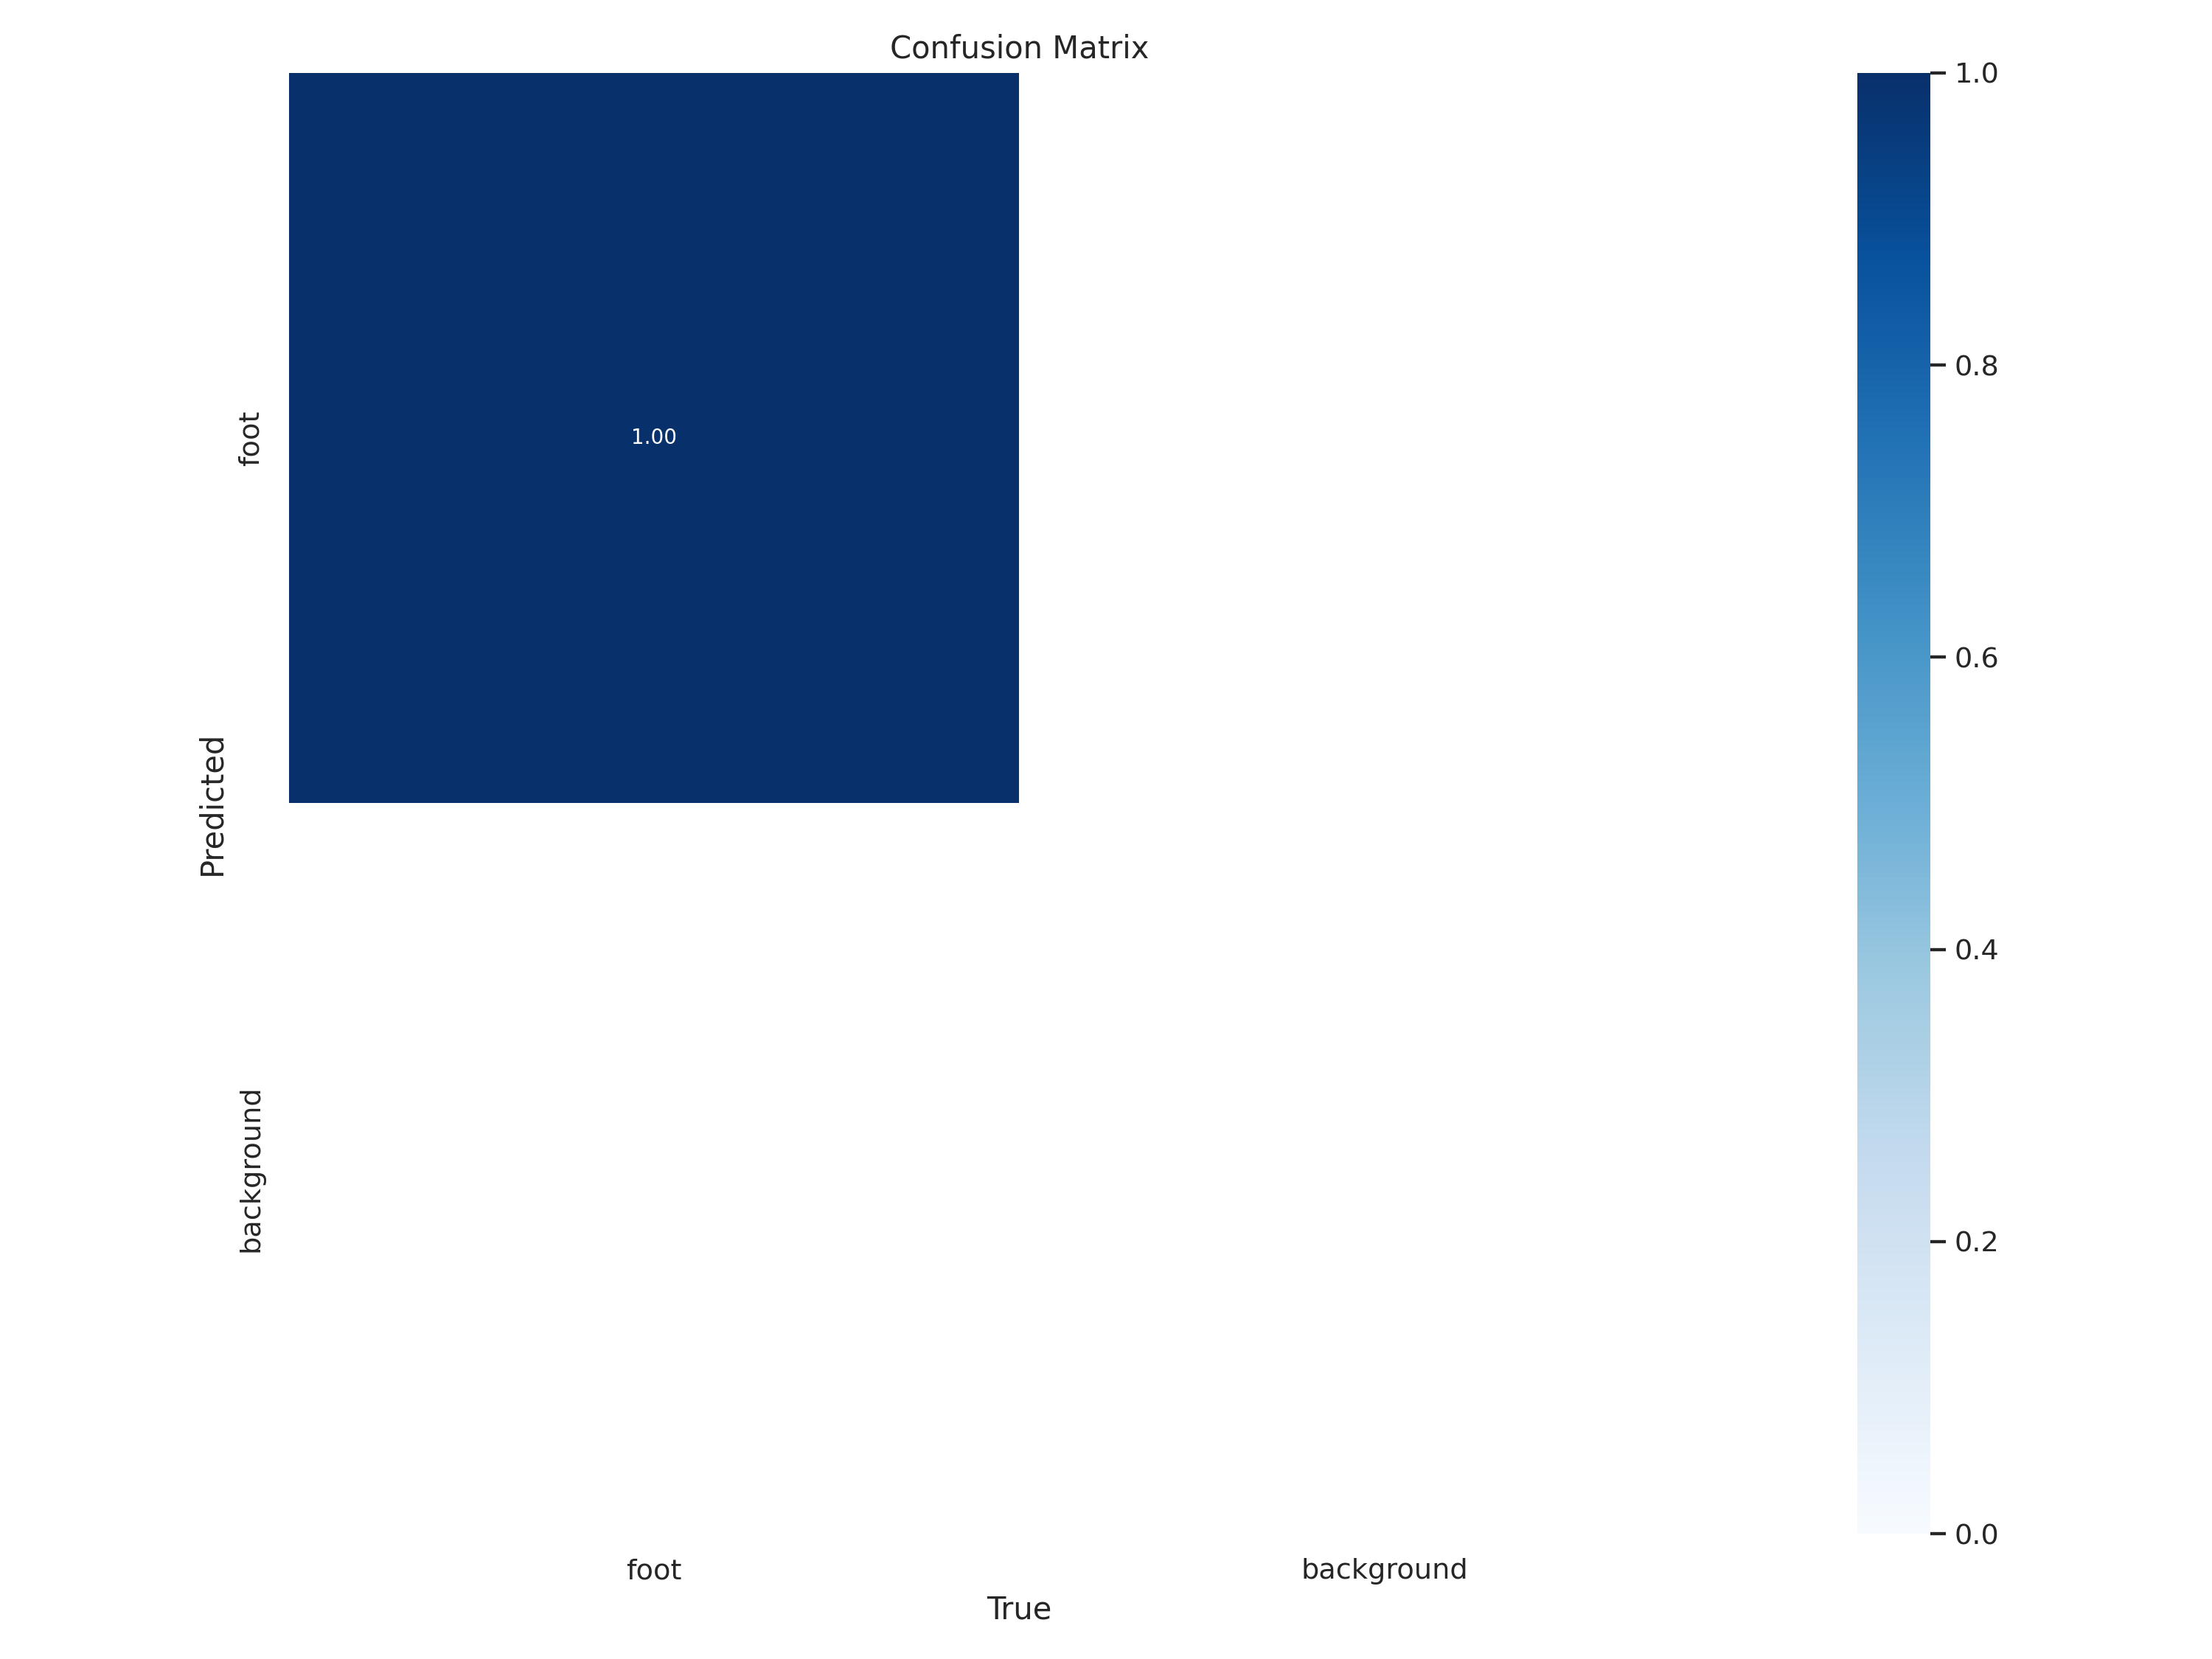

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

/content


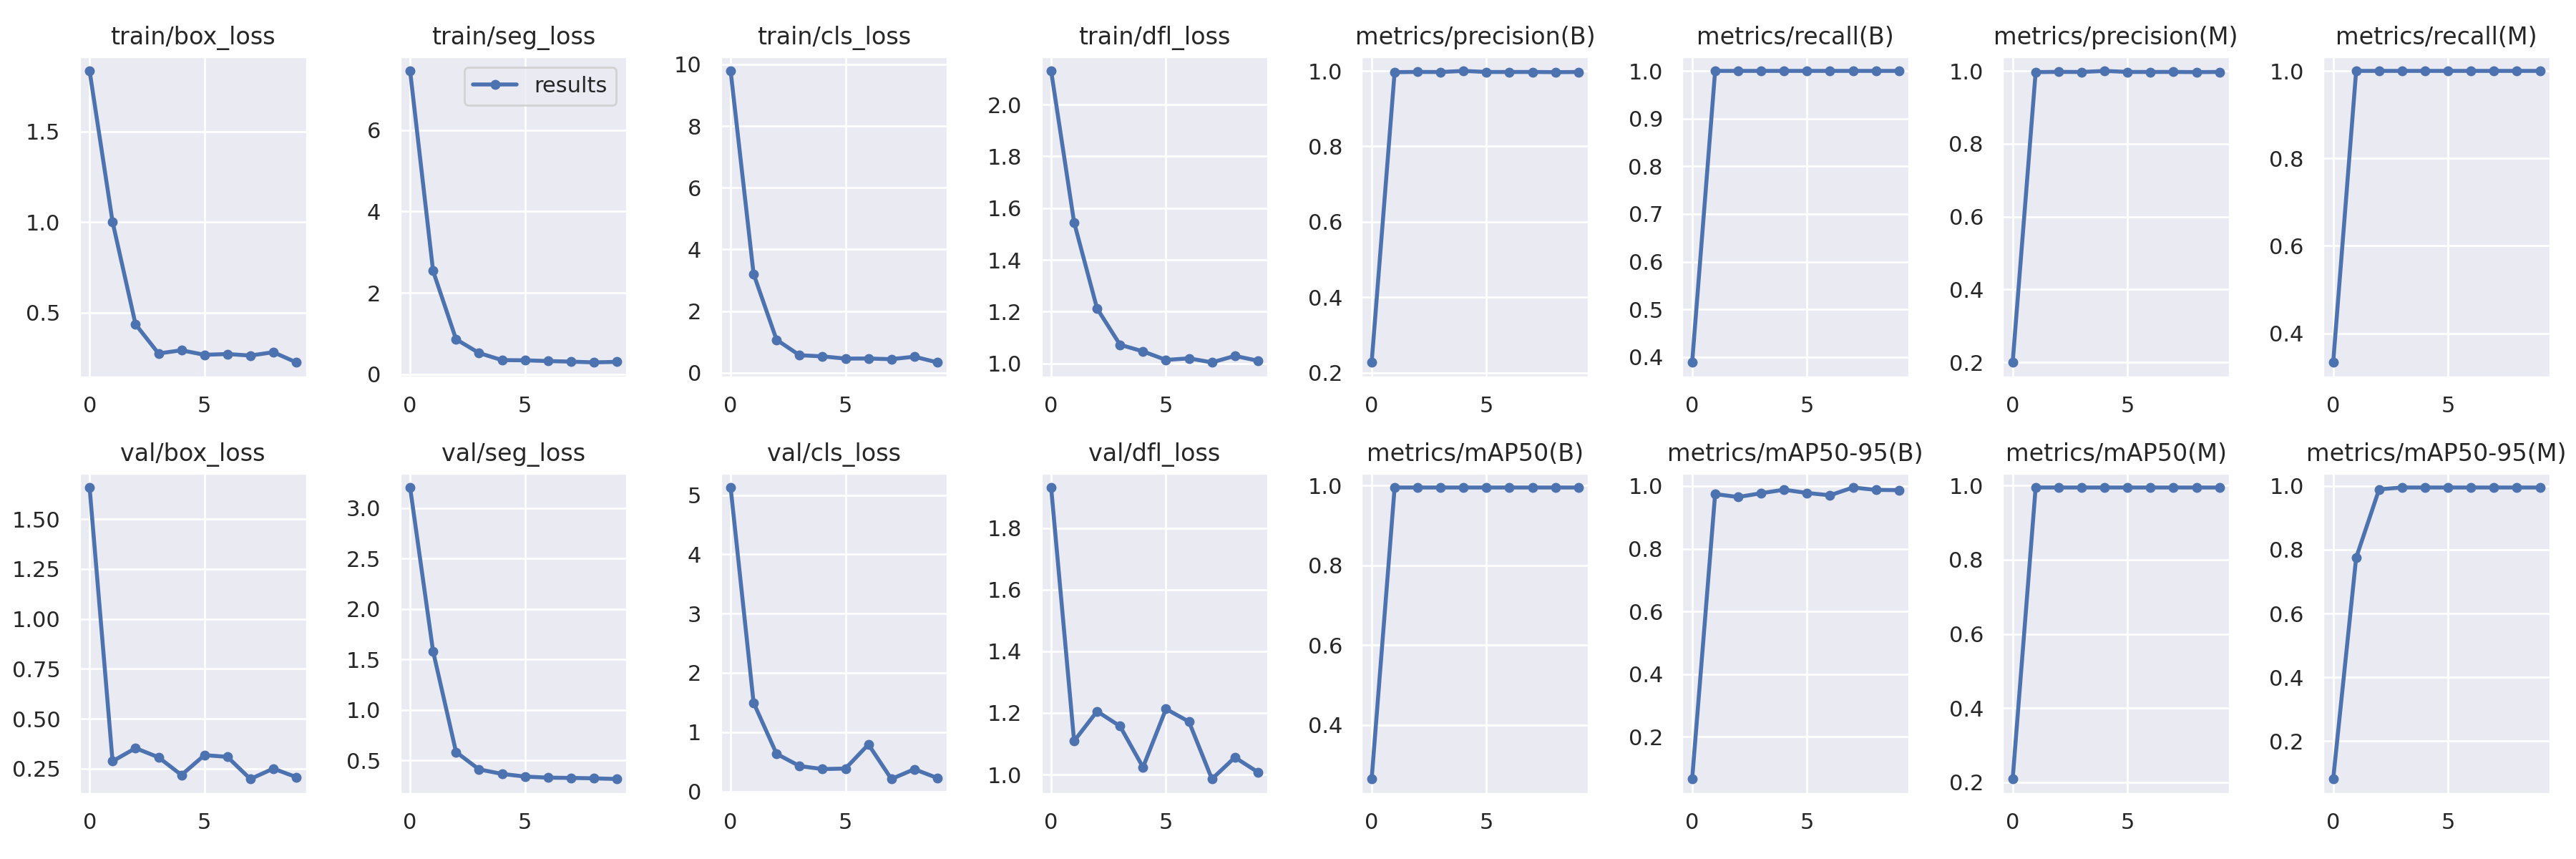

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

/content


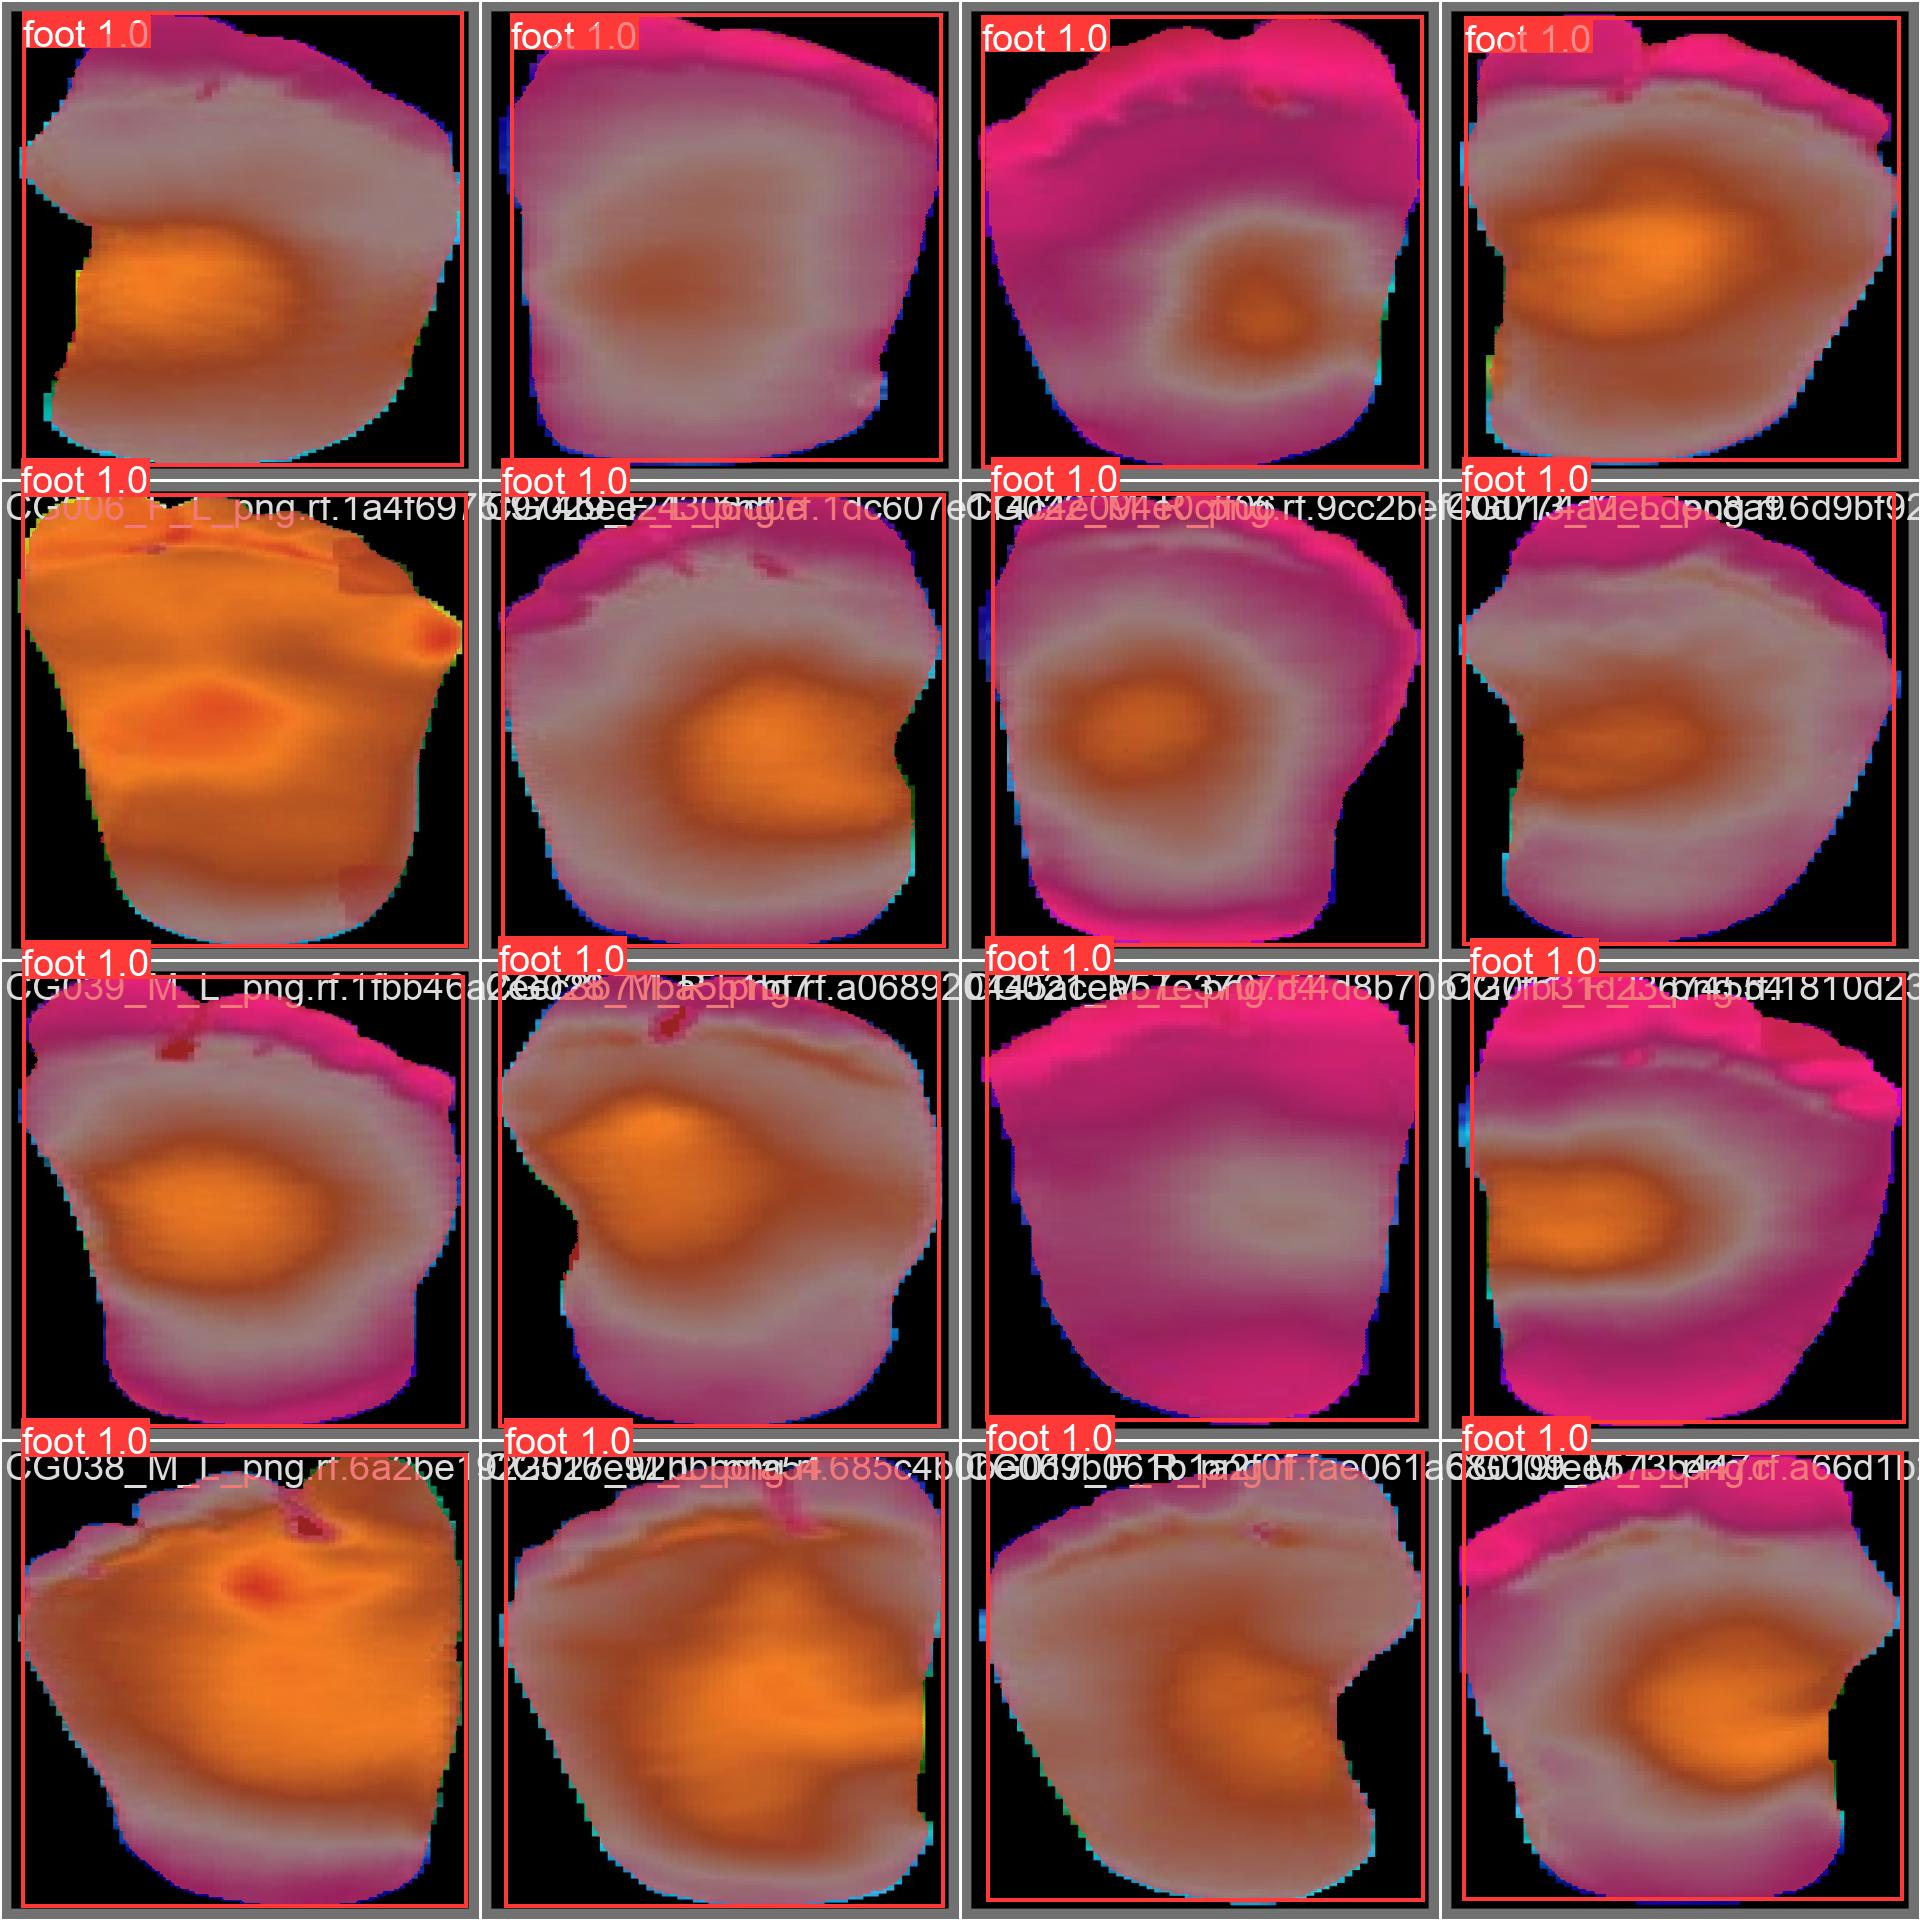

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

/content
2023-10-05 23:04:40.327202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs
val: Scanning /content/datasets/Pies-3/valid/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100% 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.29it/s]
                   all         18         18      0.997          1      0.995      0.995      0.997          1      0.995      0.995
Speed: 0.3ms pre-process, 37.4ms inference, 0.0ms loss, 6.8ms post-process per image


## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

/content
2023-10-05 23:04:59.786085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs

image 1/9 /content/datasets/Pies-3/test/images/CG001_M_R_png.rf.6b22ec6d909998fd54d3807642d2286e.jpg: 640x640 1 foot, 20.8ms
image 2/9 /content/datasets/Pies-3/test/images/CG002_M_L_png.rf.dd5d0cf75ec9b578ce4372c932cd2f6f.jpg: 640x640 1 foot, 20.7ms
image 3/9 /content/datasets/Pies-3/test/images/CG002_M_R_png.rf.5a71724a60b4a89b283cfb623824bc2d.jpg: 640x640 1 foot, 20.7ms
image 4/9 /content/datasets/Pies-3/test/images/CG004_F_R_png.rf.3245c7a31b7de9bd4559dc78d1b07a9f.jpg: 640x640 1 foot, 20.7ms
image 5/9 /content/datasets/Pies-3/test/images/CG024_F_L_png.rf.d7c9bf35e4ae4bc108bad751936082f4.jpg: 640x640 1 foot, 20.7ms
image 6/9 /content/datasets/Pies-3/test/images/CG037_M_R_png.rf.888

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

## Save & Deploy model

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload and your model weights to Roboflow Deploy for autolabeling, autoscaling inference, and using later.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv8 weights.

Run this cell to save your model weights:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8-seg", model_path=f"{HOME}/runs/segment/train/")

Dependency ultralytics==8.0.134 is required but found version=8.0.28, to fix: `pip install ultralytics==8.0.134`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/chela/pies/3
Share your model with the world at: https://universe.roboflow.com/chela/pies/model/3
